<a href="https://colab.research.google.com/github/ZhenwenZhang1108/ADL3_PartB/blob/main/PartB%E5%91%A8%E6%97%A5%E6%99%9A%E6%9C%80%E7%BB%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 1.3 MB/s eta 0:00:00


In [ ]:
import sklearn
from sklearn.metrics import f1_score
import torch
import torch.nn as nn
import torch.utils
import torch.optim as optim
import torch
from torch.utils.data import Dataset,DataLoader,random_split
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import functional as F
from torchvision.datasets.utils import download_url
from torch import Tensor
from sklearn.preprocessing import OneHotEncoder
from torcheval.metrics.functional import multiclass_f1_score
from google.colab import drive
from torcheval.metrics.functional.classification import binary_recall,multiclass_recall
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
path = "/content/drive/MyDrive/ADL32/"
os.chdir(path)
print(os.listdir())

[]


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


创建数据库(list存两个各自的数组？一个数组里装x,另一个装y?，还是必须构建x到y的一一对应关系)。
为每段序列添加一个标签（打标签的规则是什么？总不能随机打标签吧）。

对序列进行编码，abc的话采用One-hot编码应该可以。

对序列进行编码，只有abc三个字母的话采用One-hot编码应该可以。是否需要补齐<padding>？

如果我们设置batch size=1，那就不需要padding了？？？
但如此设置，恐怕挨个挪到GPU上就会很慢了，可能就得在CPU上直接训练？

In [ ]:
stats = np.zeros((2,18))
print(stats)
#自定义一个Dataset类，必需包含init, len, getitem
class CustomDataset(Dataset):
    def __init__(self):
        self.data = []
        self.targets = []

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.targets[index]

    def append(self, data, target):
        self.data.append(data)
        self.targets.append(target)

# 创建自定义数据集对象
dataset = CustomDataset()
sum = 0
k=0
# 逐个添加数据和标签
for x in range(1,19):
  for y in range(1,19):
    for z in range(1,19):
     if x+y+z>20:
       continue
     input_string = 'a'*x + 'b'*y + 'c'*z
     input_array = np.array(list(input_string)).reshape(-1, 1)
     #创建并适配 OneHotEncoder
     encoder = OneHotEncoder(sparse_output=False)
     data = torch.FloatTensor(encoder.fit_transform(input_array))
     rep = 1
     if x==y and y==z :
      target=torch.tensor(1)
      k+=10
      sum+=10
      rep = 11
      stats[1][x+y+z-3] += 10
     else:
      rep=2
      sum+=1
      target=torch.tensor(0)
      stats[0][x+y+z-3] += 1

     for i in range(1,rep):
        dataset.append(data, target)

batch_size = 1
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

print(next(iter(dataloader))[1])
print(k,sum)
print(stats[0])
print(stats[1])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
tensor([1])
60 1194
[  0.   3.   6.   9.  15.  21.  27.  36.  45.  54.  66.  78.  90. 105.
 120. 135. 153. 171.]
[10.  0.  0. 10.  0.  0. 10.  0.  0. 10.  0.  0. 10.  0.  0. 10.  0.  0.]


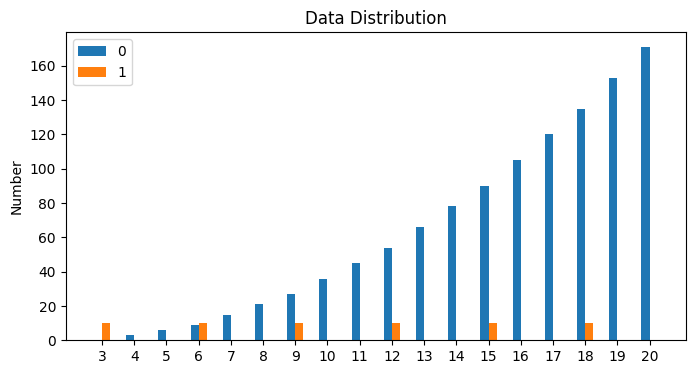

In [ ]:
x_label = list()
for x in range(3,21):
  x_label.append(str(x))

plt.figure(figsize=(8, 4))

x = np.arange(len(x_label))  # x轴刻度标签位置
width = 0.25  # 柱子的宽度
# 计算每个柱子在x轴上的位置，保证x轴刻度标签居中
# x - width/2，x + width/2即每组数据在x轴上的位置
plt.bar(x - width/2, stats[0], width, label='0')
plt.bar(x + width/2, stats[1], width, label='1')
plt.ylabel('Number')
plt.title('Distribution of postive/negative samples across lengths')
plt.xticks(x, labels=x_label)
plt.legend()
plt.title("Data Distribution")
plt.savefig("./distribution.png")

In [ ]:
print(dataset[121][0].shape)
print(dataset[122][0].shape)
print(dataset[123][0].shape)

torch.Size([17, 3])
torch.Size([18, 3])
torch.Size([19, 3])


In [ ]:
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        for texts, labels in train_loader:
            # 前向传播
            outputs = model(texts)
            loss = criterion(outputs, labels)

            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

In [ ]:
def eval_model(model,test_loader):
    model.eval()
    input = torch.tensor([])
    target = torch.tensor([])
    accstat = np.zeros((2,18))
    sta = np.zeros((2,18))
    with torch.no_grad():
      for texts, labels in test_loader:
          outputs = model(texts)
          predicted = torch.argmax(outputs,1)
          sta[labels.item()][texts.size(1)-3]+=1
          if predicted == labels:
            accstat[labels.item()][texts.size(1)-3]+=1
          input = torch.cat((input,predicted))
          target = torch.cat((target,labels))
    input = input.numpy()
    target = target.numpy()
    accuracy = 100 * (input == target).sum() / len(target)
   ## recall = binary_recall(input, target)
    f1score = f1_score(y_pred=input,y_true=target)
    print(f'Validation Accuracy: {accuracy:.2f}%')
    print(f'Validation F1 score: {f1score:.2f}')
    #sta里会有爆零的可能
    return accstat/sta, accuracy, f1score

RNN模型建立
https://pytorch.org/docs/stable/generated/torch.nn.RNN.html

In [ ]:
class RNNClassifier(nn.Module):
    def __init__(self, nlayers=1, embed_size=3, hidsize=10, bidirect=False, output_size=2):
        super(RNNClassifier, self).__init__()
        #one-hot编码，字母本身没有额外信息需要学习，所以不需要embedding层??
        self.embed = nn.Linear(in_features=embed_size,out_features=hidsize)
        self.rnn = nn.RNN(input_size=hidsize, num_layers=nlayers, hidden_size=hidsize, bidirectional=bidirect, batch_first=True)
        if bidirect==True:
          self.bi=2
        else:
          self.bi=1
        self.fc = nn.Linear(hidsize*self.bi*nlayers,output_size)
    def forward(self, x):
        x= self.embed(x)
        output,h_n = self.rnn(input=x)
        h_n = h_n.permute(1,0,2) #这里要小心，即使开了batch_first=True,第一个维度上也不是batch_size，这是pytorch.RNN的设定
        h_n = torch.flatten(h_n,start_dim=-2)
        out = self.fc(h_n)
        return out #注意这里的output没做softmax

In [ ]:
model_rnn = RNNClassifier(hidsize=100, bidirect=True).to(device)
criterion_CE = nn.CrossEntropyLoss() #自带softmax
optimizer_adam = optim.Adam(model_rnn.parameters(), lr=0.001)

x = torch.rand(6,11,3) #(batch_size,seq_len,embed_size)
y = model_rnn(x)
z = torch.argmax(y,1)
print(z.shape)

torch.Size([6])


In [ ]:
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

trainloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print(len(trainloader))
print(len(testloader))

835
359


In [ ]:
# 训练模型
train_model(model=model_rnn, train_loader=trainloader, criterion=criterion_CE, optimizer = optimizer_adam, num_epochs=15)
# 测试模型


Epoch [1/15], Loss: 0.2128
Epoch [2/15], Loss: 0.1886
Epoch [3/15], Loss: 0.1919
Epoch [4/15], Loss: 0.1747
Epoch [5/15], Loss: 0.1513
Epoch [6/15], Loss: 0.1517
Epoch [7/15], Loss: 0.1345
Epoch [8/15], Loss: 0.1038
Epoch [9/15], Loss: 0.1009
Epoch [10/15], Loss: 0.1227
Epoch [11/15], Loss: 0.1227
Epoch [12/15], Loss: 0.1147
Epoch [13/15], Loss: 0.1111
Epoch [14/15], Loss: 0.1099
Epoch [15/15], Loss: 0.1013


In [ ]:
eval_model(model_rnn,testloader)
#torch.save(model_rnn.state_dict(), './model_rnn1.pth')

Validation Accuracy: 96.38%
Validation F1 score: 0.67


<ipython-input-41-80568ad53960>:24: RuntimeWarning: invalid value encountered in divide
  return accstat/sta, accuracy, f1score


(array([[       nan, 1.        , 1.        , 0.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 0.95454545, 1.        , 1.        , 1.        ,
         0.97826087, 1.        , 0.95348837],
        [1.        ,        nan,        nan, 1.        ,        nan,
                nan, 0.        ,        nan,        nan, 1.        ,
                nan,        nan, 0.        ,        nan,        nan,
         1.        ,        nan,        nan]]),
 96.37883008356546,
 0.6666666666666666)

LSTM模型
https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, nlayers=1, embed_size=3, hidsize=100, bidirect=False, output_size=2):
        super(LSTMClassifier, self).__init__()
        self.embed = nn.Linear(in_features=embed_size,out_features=hidsize)
        self.lstm = nn.LSTM(input_size=hidsize, num_layers=nlayers, hidden_size=hidsize, bidirectional=bidirect, batch_first=True)
        if bidirect==True:
          self.bi=2
        else:
          self.bi=1
        self.fc = nn.Linear(hidsize*self.bi*nlayers,output_size)
    def forward(self, x):
        x = self.embed(x)
        output, (h_n, c_n) = self.lstm(input=x)
        h_n = h_n.permute(1,0,2) #这里要小心，即使开了batch_first=True,第一个维度上也不是batch_size，这是pytorch.RNN的设定
        h_n = torch.flatten(h_n,start_dim=-2)
        out = self.fc(h_n)
        return out #注意这里的output没做softmax

In [ ]:
model_lstm = LSTMClassifier().to(device)
criterion_CE = nn.CrossEntropyLoss() #自带softmax
optimizer_adam = optim.Adam(model_lstm.parameters(), lr=0.001)

x = torch.rand(6,11,3) #(batch_size,seq_len,embed_size)
y = model_lstm(x)
z = torch.argmax(y,1)
print(z.shape)

torch.Size([6])


In [ ]:
train_model(model=model_lstm, train_loader=trainloader, criterion=criterion_CE, optimizer = optimizer_adam, num_epochs=10)
# 测试模型

Epoch [1/10], Loss: 0.1995
Epoch [2/10], Loss: 0.1791
Epoch [3/10], Loss: 0.1598
Epoch [4/10], Loss: 0.1486
Epoch [5/10], Loss: 0.1244
Epoch [6/10], Loss: 0.0756
Epoch [7/10], Loss: 0.0500
Epoch [8/10], Loss: 0.0325
Epoch [9/10], Loss: 0.0149
Epoch [10/10], Loss: 0.0596


In [ ]:
eval_model(model_lstm,testloader)

Validation Accuracy: 99.44%
Validation F1 score: 0.95


<ipython-input-41-80568ad53960>:24: RuntimeWarning: invalid value encountered in divide
  return accstat/sta, accuracy, f1score


(array([[nan, nan,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.],
        [ 1., nan, nan,  1., nan, nan,  1., nan, nan,  1., nan, nan,  1.,
         nan, nan,  0., nan, nan]]),
 99.44289693593315,
 0.9500000000000001)

In [ ]:
torch.save(model_lstm.state_dict(), './model_lstm1.pth')

In [ ]:
#model_rnn.load_state_dict(torch.load("./model_rnn1.pth"))
#通过 load_state_dict 函数加载参数，torch.load() 函数中重要的一步是反序列化。
#model_lstm.load_state_dict(torch.load("./model_lstm1.pth"))

acc_rnn,_,_ = eval_model(model_rnn,testloader)
acc_lstm,_,_ = eval_model(model_lstm,testloader)



Validation Accuracy: 96.38%
Validation F1 score: 0.55


<ipython-input-41-80568ad53960>:24: RuntimeWarning: invalid value encountered in divide
  return accstat/sta, accuracy, f1score


Validation Accuracy: 99.44%
Validation F1 score: 0.95


<ipython-input-41-80568ad53960>:24: RuntimeWarning: invalid value encountered in divide
  return accstat/sta, accuracy, f1score


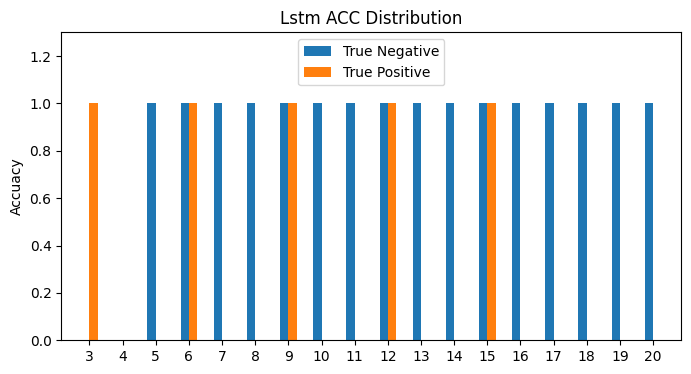

In [ ]:
plt.figure(figsize=(8, 4))

x = np.arange(len(x_label))  # x轴刻度标签位置
width = 0.25  # 柱子的宽度
# 计算每个柱子在x轴上的位置，保证x轴刻度标签居中
# x - width/2，x + width/2即每组数据在x轴上的位置
plt.bar(x - width/2, acc_lstm[0], width, label='True Negative')
plt.bar(x + width/2, acc_lstm[1], width, label='True Positive')
plt.ylabel('Accuacy')
plt.xticks(x, labels=x_label)
plt.ylim(0,1.3)
plt.legend()
plt.title("Lstm ACC Distribution")
plt.savefig("./lstm_distribution.png")

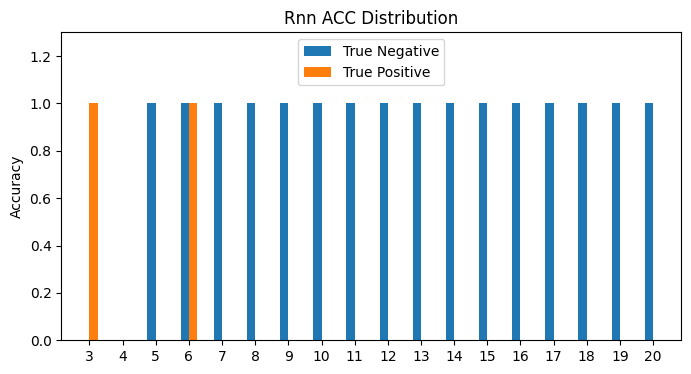

In [ ]:
plt.figure(figsize=(8, 4))

x = np.arange(len(x_label))  # x轴刻度标签位置
width = 0.25  # 柱子的宽度
# 计算每个柱子在x轴上的位置，保证x轴刻度标签居中
# x - width/2，x + width/2即每组数据在x轴上的位置
plt.bar(x - width/2, acc_rnn[0], width, label='True Negative')
plt.bar(x + width/2, acc_rnn[1], width, label='True Positive')
plt.ylabel('Accuracy')
plt.title('2 datasets')
plt.xticks(x, labels=x_label)
plt.ylim(0,1.3)
plt.legend()
plt.title("Rnn ACC Distribution")
plt.savefig("./Rnn_distribution.png")

参数优化：是否进行embedding; hidden_size取50，75，100.。。。。

In [ ]:
!pip install --quiet wandb
import wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.0/289.0 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.6 MB/s eta 0:00:00


In [ ]:
import math
sweep_rnn_config = {
                'method': 'random',
                'metric': {'goal': 'minimize', 'name': 'loss'},
                'parameters': {
                    'nlayers': {'values':[1,2]},
                    'hidsize': {'values':[50,75,100]},
                    'bidirect': {'values': [True,False]},
                    'epochs': {'values': [10,15,20]}
                }
 }

sweep_rnn_id = wandb.sweep(sweep_rnn_config, project="RNN3_sweep")

Create sweep with ID: 0p6m1v2n
Sweep URL: https://wandb.ai/adlh5g3/RNN3_sweep/sweeps/0p6m1v2n


In [ ]:
def train_rnn_sweep(config=None):
    with wandb.init(project='RNN3_sweep', config=config):
        config = wandb.config
        net = RNNClassifier(nlayers=config.nlayers, hidsize=config.hidsize, bidirect=config.bidirect)
        loss = nn.CrossEntropyLoss() #自带softmax
        optimizer = optim.Adam(net.parameters(), lr=0.001)

        wandb.watch(net, loss, log="all")

        train_model(model=net, train_loader=trainloader, criterion=loss, optimizer = optimizer, num_epochs=config.epochs)

        _,acc,f1 = eval_model(model=net, test_loader=testloader)
        wandb.log({'f1_val': f1, 'acc_val': acc})
        print('Finished Training')

wandb.agent(sweep_rnn_id, function=train_rnn_sweep, count=15)

In [ ]:
sweep_lstm_config = {
                'method': 'random',
                'metric': {'goal': 'minimize', 'name': 'loss'},
                'parameters': {
                    'nlayers': {'values':[1,2]},
                    'hidsize': {'values':[50,75,100]},
                    'bidirect': {'values': [True,False]},
                    'epochs': {'values': [10,15,20]}
                }
 }

sweep_lstm_id = wandb.sweep(sweep_lstm_config, project="LSTM3_sweep")
def train_lstm_sweep(config=None):
    with wandb.init(project='LSTM3_sweep', config=config):
        config = wandb.config
        net = LSTMClassifier(nlayers=config.nlayers, hidsize=config.hidsize, bidirect=config.bidirect)
        loss = nn.CrossEntropyLoss() #自带softmax
        optimizer = optim.Adam(net.parameters(), lr=0.001)

        wandb.watch(net, loss, log="all")

        train_model(model=net, train_loader=trainloader, criterion=loss, optimizer = optimizer, num_epochs=config.epochs)

        _,acc,f1 = eval_model(model=net, test_loader=testloader)
        wandb.log({'f1_val': f1, 'acc_val': acc})
        print('Finished Training')

wandb.agent(sweep_lstm_id, function=train_lstm_sweep, count=15)

泛化能力评估：长度21-50

In [ ]:
#自定义一个Dataset类，必需包含init, len, getitem
class CustomDataset(Dataset):
    def __init__(self):
        self.data = []
        self.targets = []

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.targets[index]

    def append(self, data, target):
        self.data.append(data)
        self.targets.append(target)


In [ ]:
stats_general = np.zeros((2,30))

# 创建自定义数据集对象
dataset_general = CustomDataset()
sum = 0
k=0
# 逐个添加数据和标签
for x in range(1,50):
  for y in range(1,50):
    for z in range(1,50):
     if x+y+z<21 or x+y+z>50:
       continue
     input_string = 'a'*x + 'b'*y + 'c'*z
     sum+=1
     input_array = np.array(list(input_string)).reshape(-1, 1)
     #创建并适配 OneHotEncoder
     encoder = OneHotEncoder(sparse_output=False)
     data = torch.FloatTensor(encoder.fit_transform(input_array))
     if x==y and y==z :
      target=torch.tensor(1)
      k+=1
      stats_general[1][x+y+z-21] += 1
     else:
      target=torch.tensor(0)
      stats_general[0][x+y+z-21] += 1

     dataset_general.append(data, target)

print(sum,k)
print(len(dataset_general))

18460 10
18460


In [ ]:
# 创建 DataLoader
general_dataloader = DataLoader(dataset_general, batch_size=1)

print(len(general_dataloader))


18460


In [ ]:
def eval_general_model(model,test_loader):
    model.eval()
    input = torch.tensor([])
    target = torch.tensor([])
    accstat = np.zeros((2,30))
    sta = np.zeros((2,30))
    with torch.no_grad():
      for texts, labels in test_loader:
          outputs = model(texts)
          predicted = torch.argmax(outputs,1)
          sta[labels.item()][texts.size(1)-21]+=1
          if predicted == labels:
            accstat[labels.item()][texts.size(1)-21]+=1
          input = torch.cat((input,predicted))
          target = torch.cat((target,labels))
    input = input.numpy()
    target = target.numpy()
    accuracy = 100 * (input == target).sum() / len(target)
   ## recall = binary_recall(input, target)
    f1score = f1_score(y_pred=input,y_true=target)
    #sta里会有爆零的可能
    return accstat/sta, accuracy, f1score

In [ ]:
#model_rnn.load_state_dict(torch.load("./model_rnn1.pth"))
#通过 load_state_dict 函数加载参数，torch.load() 函数中重要的一步是反序列化。
#model_lstm.load_state_dict(torch.load("./model_lstm1.pth"))

acc_rnn,_,_ = eval_general_model(model_rnn,general_dataloader)
#acc_lstm,_,_ = eval_general_model(model_lstm,general_dataloader)

<ipython-input-76-748824fa47ff>:22: RuntimeWarning: invalid value encountered in divide
  return accstat/sta, accuracy, f1score


In [ ]:
x_general_label = list()
for x in range(21,51):
  x_general_label.append(str(x))

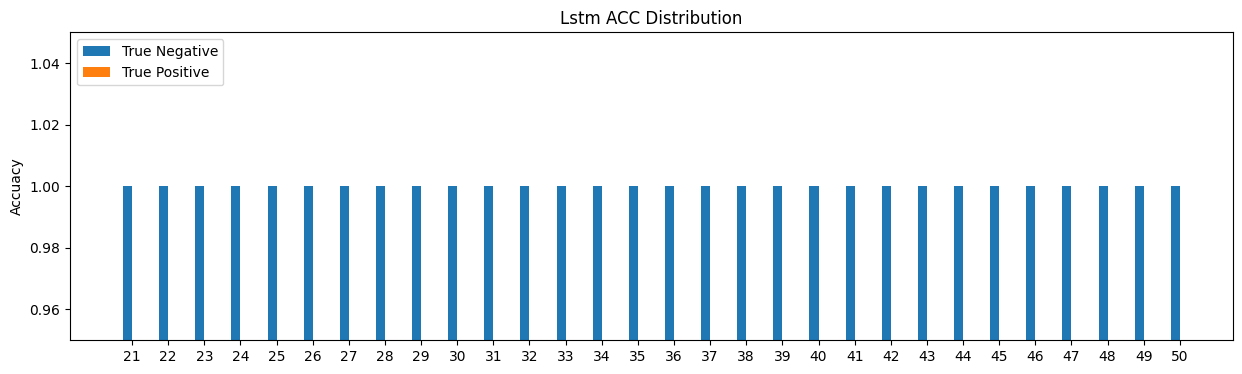

In [ ]:
plt.figure(figsize=(15, 4))

x = np.arange(len(x_general_label))  # x轴刻度标签位置
width = 0.25  # 柱子的宽度
# 计算每个柱子在x轴上的位置，保证x轴刻度标签居中
# x - width/2，x + width/2即每组数据在x轴上的位置
plt.bar(x - width/2, acc_lstm[0], width, label='True Negative')
plt.bar(x + width/2, acc_lstm[1], width, label='True Positive')
plt.ylabel('Accuacy')
plt.xticks(x, labels=x_general_label)
plt.ylim(0.95,1.05)
plt.legend()
plt.title("Lstm ACC Distribution")
plt.savefig("./lstm_general_distribution.png")

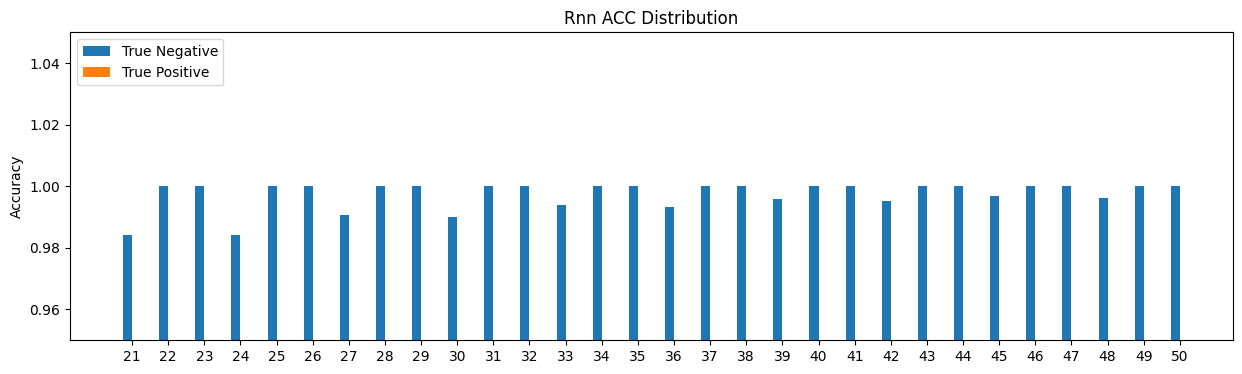

In [ ]:
plt.figure(figsize=(15, 4))

x = np.arange(len(x_general_label))  # x轴刻度标签位置
width = 0.25  # 柱子的宽度
# 计算每个柱子在x轴上的位置，保证x轴刻度标签居中
# x - width/2，x + width/2即每组数据在x轴上的位置
plt.bar(x - width/2, acc_rnn[0], width, label='True Negative')
plt.bar(x + width/2, acc_rnn[1], width, label='True Positive')
plt.ylabel('Accuracy')
plt.xticks(x, labels=x_general_label)
plt.ylim(0.95,1.05)
plt.legend()
plt.title("Rnn ACC Distribution")
plt.savefig("./Rnn_general_distribution.png")

In [ ]:
print(model_lstm)
print(model_rnn)

LSTMClassifier(
  (embed): Linear(in_features=3, out_features=100, bias=True)
  (lstm): LSTM(100, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=2, bias=True)
)
RNNClassifier(
  (embed): Linear(in_features=3, out_features=100, bias=True)
  (rnn): RNN(100, 100, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=200, out_features=2, bias=True)
)
